In [10]:
import math
import warnings
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif


!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

In [11]:
def save_df(df, name="temp"):
    """
    Saves the given DataFrame to a CSV file named '<name>.csv'
    """
    filename = f"{name}.csv"
    df.to_csv(filename, index=True)  # set index=False if you don't want to save the index
    print(f"Saved DataFrame to {filename}")

def clean_and_drop(X: pd.DataFrame, missing_threshold: float = 0.10) -> pd.DataFrame:
    missing_ratios = X.isnull().mean()
    to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
    print(f"Dropping columns due to missing data > {int(missing_threshold * 100)}%: {to_drop}")
    X = X.drop(columns=to_drop)

    before = len(X)
    X = X.dropna()
    after = len(X)
    print(f"Dropped {before - after} rows with any remaining NaNs.")

    return X

In [12]:
seed = 1234
warnings.filterwarnings('ignore')
diabetes_df = fetch_ucirepo(id=296)
#warnings.resetwarnings()

X = diabetes_df.data.features
y = diabetes_df.data.targets

# Clean and normalize the features
X = clean_and_drop(X, missing_threshold=0.05)
X = pd.get_dummies(X, drop_first=True)

# Switch label to binary classification
y = y.loc[X.index]
y = y.replace({'<30': 1, 'NO': 0, '>30': 0})

Dropping columns due to missing data > 5%: ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']
Dropped 3713 rows with any remaining NaNs.


In [13]:
# First split: Train vs (Validation + Test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# Second split: Train vs Validation (from the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=seed)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [14]:
def plot_roc_curve(clf, X_val, y_val, model_name="Model"):
    y_proba = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_learning_curve_errors(clf, X_tr: np.array, y_tr: np.array, 
                                X_te: np.array, y_te: np.array, 
                                seed: int, train_sizes: list[int], 
                                title: str = "Learning Curve") -> None:
    
    tr_err = []
    te_err = []

    for n_tr in train_sizes:
        #print(f"Training with {n_tr} samples...")
        # Slice the training set
        X_subset = X_tr[:n_tr, :]
        y_subset = y_tr[:n_tr]

        # Clone model to avoid state carryover
        model = clone(clf)
        model.fit(X_subset, y_subset)

        # Compute errors
        tr_pred = model.predict(X_subset)
        te_pred = model.predict(X_te)
        tr_err.append(1.0 - accuracy_score(y_subset, tr_pred))
        te_err.append(1.0 - accuracy_score(y_te, te_pred))

    # Plotting
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, tr_err, marker='o', label='Training Error')
    plt.plot(train_sizes, te_err, marker='s', label='Test Error')
    plt.xlabel("Training Set Size")
    plt.ylabel("Error Rate")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     17398
           1       0.17      0.02      0.04      2213

    accuracy                           0.88     19611
   macro avg       0.53      0.50      0.49     19611
weighted avg       0.81      0.88      0.83     19611



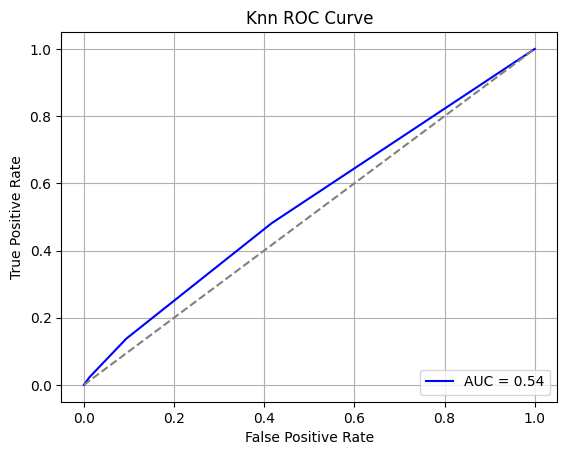

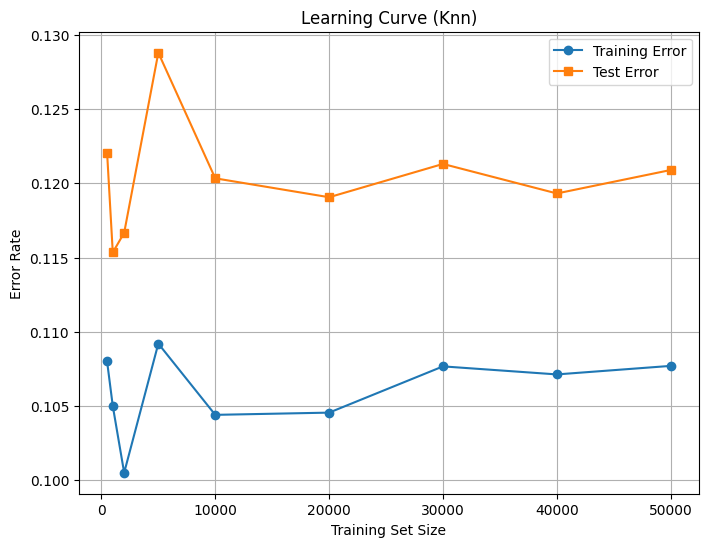

In [15]:
k_val = 5
clf = KNeighborsClassifier(n_neighbors=k_val)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_val_scaled)

print(classification_report(y_val, y_pred))

plot_roc_curve(clf, X_test_scaled, y_test, model_name="Knn")

train_sizes = [500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]

plot_learning_curve_errors(clf, X_train_scaled, y_train.values.ravel(),
                           X_test_scaled, y_test.values.ravel(),
                           seed=seed, train_sizes=train_sizes,
                           title="Learning Curve (Knn)")

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     17398
           1       0.12      0.02      0.04      2213

    accuracy                           0.87     19611
   macro avg       0.50      0.50      0.48     19611
weighted avg       0.80      0.87      0.83     19611



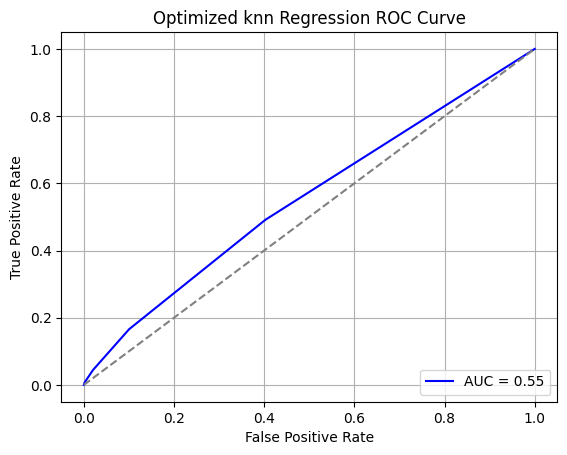

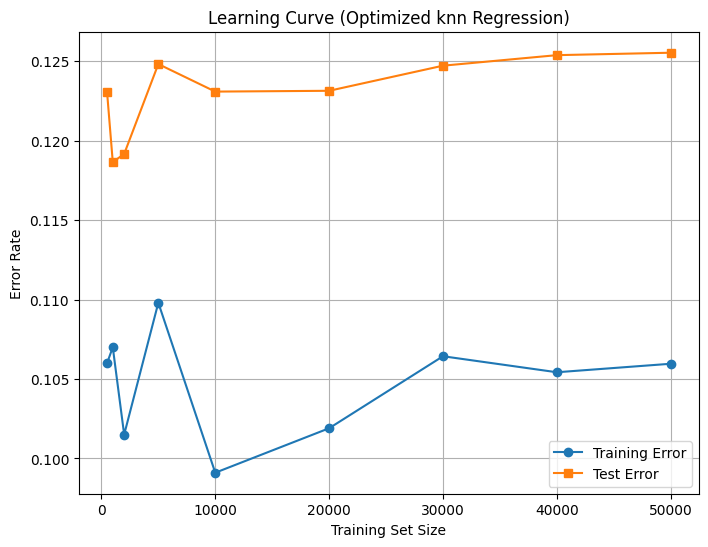

In [16]:
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

tuned_clf = KNeighborsClassifier(n_neighbors=k_val)
tuned_clf.fit(X_train_selected, y_train)

y_pred = tuned_clf.predict(X_val_selected)

print(classification_report(y_test, y_pred))

plot_roc_curve(tuned_clf, X_test_selected, y_test, model_name="Optimized knn Regression")

train_sizes = [500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]

plot_learning_curve_errors(tuned_clf, X_train_selected, y_train.values.ravel(),
                           X_test_selected, y_test.values.ravel(),
                           seed=seed, train_sizes=train_sizes,
                           title="Learning Curve (Optimized knn Regression)")

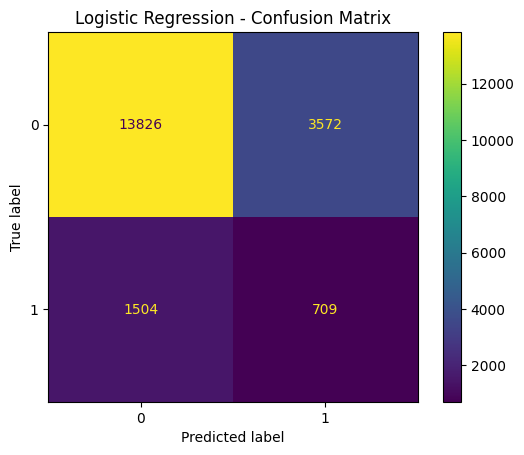

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

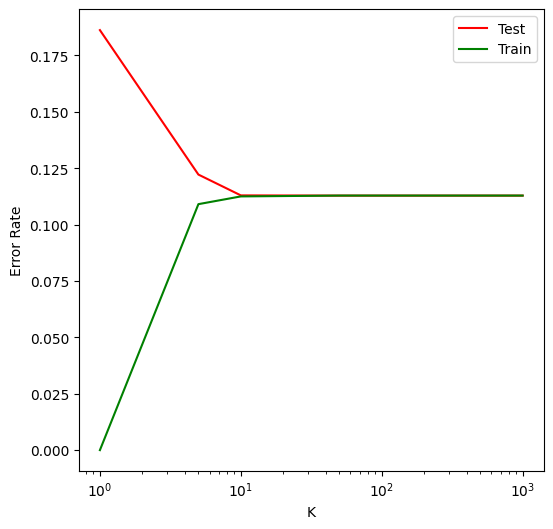

In [19]:
figure, axes = plt.subplots(1, figsize=(6, 6))
k_vals = [1, 5, 10, 50, 100, 1000]
axes.set_xlabel("K")
axes.set_ylabel("Error Rate")
te_error = []
tr_error = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train.values.ravel())
    y_pred_te = knn.predict(X_val_scaled)
    y_pred_tr = knn.predict(X_train_scaled)
    e_te = 1 - accuracy_score(y_val.values.ravel(), y_pred_te)
    e_tr = 1 - accuracy_score(y_train.values.ravel(), y_pred_tr)
    te_error.append(e_te)
    tr_error.append(e_tr)
axes.semilogx(k_vals, te_error, color='red', label='Test')
axes.semilogx(k_vals, tr_error, color='green', label='Train')
axes.legend()

